<a href="https://colab.research.google.com/github/mAenon/kankitu_crassification/blob/master/kankitsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
# google drive のマウント
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [129]:
# 参考 https://qiita.com/God_KonaBanana/items/2cf829172087d2423f58

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

In [130]:
# 環境の指定
n_categories = -1 #分類数
batch_size = 32


In [131]:
# データの準備
# アノテーション
import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

data_dir = "/content/drive/My Drive/kankitsu_data/"
classes = os.listdir(data_dir)
n_categories = len(classes)

data_list = [["category", "category_num", "path"]]

for i, category in enumerate(classes):
    img_list = os.listdir(data_dir + category)
    for img in img_list: 
      data_list.append([category, i, data_dir + category + "/" + img])

data_df = pd.DataFrame(data_list[1:], columns=data_list[0])
data_df.head()

x_path_list = data_df["path"]
y_list = data_df["category_num"]

In [132]:
# x_path_list より画像の読み込み
x_list = []

for path in x_path_list:
  img = cv2.imread(path)
  img = img[::-1]
  # cv2_imshow(img) #やらないこと
  x_list.append(img.copy())

In [133]:
# train_test_splitを使用してデータの分割を行う

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, train_size=0.9, test_size=None, stratify=y_list)
x_train = np.array(x_train)
x_test  = np.array(x_test )
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test )

In [141]:
# データ拡張 の準備
# model.fit_generatorを使用する
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0 / 255, zoom_range=0.2, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255, zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train, shuffle=True, batch_size = x_train.shape[0] // 20)
test_generator  = test_datagen.flow( x_test ,y_test , shuffle=True ,batch_size = x_test.shape[0]  // 20)

In [143]:
# モデル構築 時間かかる

# VGG16モデル
base_model = VGG16(weights="imagenet", include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))

# 追加のレイヤー
vgg16_output = base_model.output
flatten = Flatten()(vgg16_output)
Dense1 = Dense(1024, activation="relu")(flatten)
prediction = Dense(n_categories, activation="softmax")(Dense1)

# モデルを新たに構築
model = Model(inputs=base_model.input, outputs=prediction)

In [144]:
# 重さの指定
for layer in base_model.layers[:15]:
    layer.trainable = False

In [145]:
# compile
model.compile(optimizer=SGD(lr=1e-3, momentum=0.9),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [138]:
# summary
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [146]:
# モデルの学習 model.fit_generatorを使用
result = model.fit_generator(train_generator, epochs=50, verbose=1, validation_data=test_generator)
# result = model.fit(x_train, y_train, batch_size=x_train.shape[0] // 10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
21/21 [==============================] - 8s 391ms/step - loss: 1.9476 - accuracy: 0.2378 - val_loss: 1.5924 - val_accuracy: 0.3800
Epoch 2/50
21/21 [==============================] - 8s 384ms/step - loss: 1.1588 - accuracy: 0.5422 - val_loss: 1.2512 - val_accuracy: 0.4400
Epoch 3/50
21/21 [==============================] - 8s 384ms/step - loss: 0.7571 - accuracy: 0.7111 - val_loss: 1.0497 - val_accuracy: 0.6400
Epoch 4/50
21/21 [==============================] - 8s 383ms/step - loss: 0.5566 - accuracy: 0.7689 - val_loss: 1.0383 - val_accuracy: 0.5800
Epoch 5/50
21/21 [==============================] - 8s 389ms/step - loss: 0.4358 - accuracy: 0.8644 - val_loss: 0.8395 - val_accuracy: 0.6800
Epoch 6/50
21/21 [==============================] - 8s 380ms/step - loss: 0.2491 - accuracy: 0.9133 - val_loss: 0.7174 - val_accuracy: 0.7000
Epoch 7/50
21/21 [==============================] - 8s 382ms/step - loss: 0.1521 - accuracy: 0.9667 - val_loss: 1.0710 - val_accuracy: 0.6200
Epoch 

categories :
・ orange
・ kiwi
・ lemon
・ decopon
・ hassaku


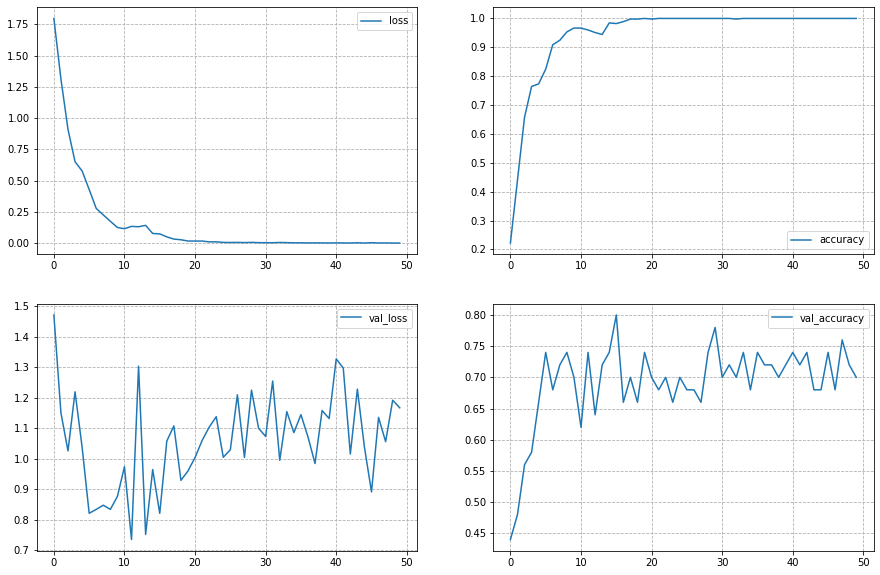

In [140]:
categories = os.listdir("/content/drive/My Drive/kankitsu_data/")
print("categories :")
for category in categories:
  print("・", category)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for i, key in enumerate(result.history.keys()):
  plt.subplot(2, 2, i + 1)
  plt.grid(linestyle="--")
  plt.plot(result.history[key], label = key)
  plt.legend()